In [1]:
#Importing libraries
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
from matplotlib.dates import DateFormatter, DayLocator
from pylab import rcParams
import pickle
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
%matplotlib inline
import warnings
import torch
from torch import optim
from torch.nn import functional as F
from tqdm import tqdm
from nbeats_pytorch.model import NBeatsNet
from trainer_pytorch import save

warnings.filterwarnings(action='ignore', message='Setting attributes')

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

# Data Preprocessing

In [2]:
df=pd.read_csv("Dataset.csv")  #Reading the dataset

df=df.drop(['VORJAHRESWERT','VERAEND_VORMONAT_PROZENT','VERAEND_VORJAHRESMONAT_PROZENT','ZWOELF_MONATE_MITTELWERT'],axis=1) #Removing unwanted columns

df.columns = ['Category','Accident_Type','Year','Month','Value'] #Renaming for ease

categories=list(set(list(df['Category']))) #Listing all categories

accidents=list(set(list(df['Accident_Type']))) #Listing all Accidents

In [3]:
categories

['Verkehrsunfälle', 'Alkoholunfälle', 'Fluchtunfälle']

# Removing unwanted rows

In [4]:
cond = df.Month == 'Summe' #Removing rows with sum of all values for each category

rows = df.loc[cond, :]

df.drop(rows.index, inplace=True)

# Changing date format

In [5]:
df['Month'] = pd.to_datetime(df['Month'],format='%Y%m')

In [6]:
final=[]

# Removing other accidents types apart from "insgesamt"

In [7]:
for i in categories:
    
    df_tmp = pd.DataFrame(columns=df.columns)

    cond = df.Category == i #Condition to select category

    rows = df.loc[cond, :]

    df_tmp = df_tmp.append(rows, ignore_index=True)

    df.drop(rows.index, inplace=True)

    cond = df_tmp.Accident_Type != 'insgesamt' #Condition to select other accidents types for removal

    rows = df_tmp.loc[cond, :]

    df_tmp.drop(rows.index, inplace=True)
    
    final.append(df_tmp)

# Converting each dataframe to time indexed series

In [8]:
uni=[]

In [9]:
for i in final:
    
    data=i
    
    data = data.set_index('Month')

    data.index

    y=data['Value']

    y=y['2020':]
       
    uni.append(y)

# Individual Plots for the entire time period from 2000-2020

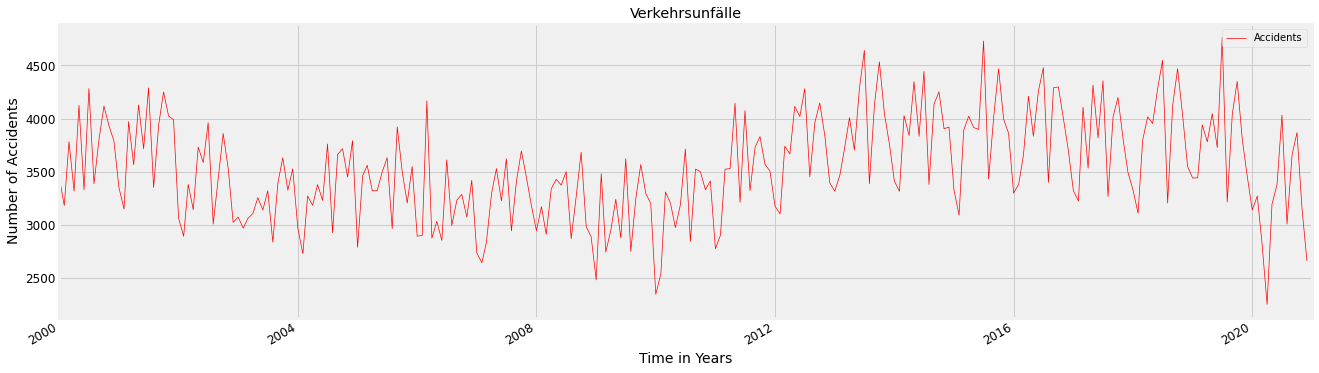

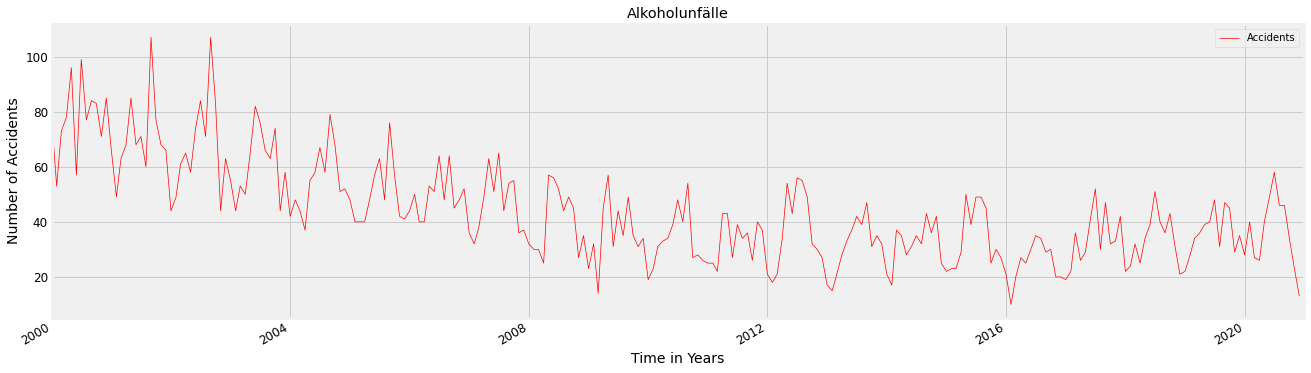

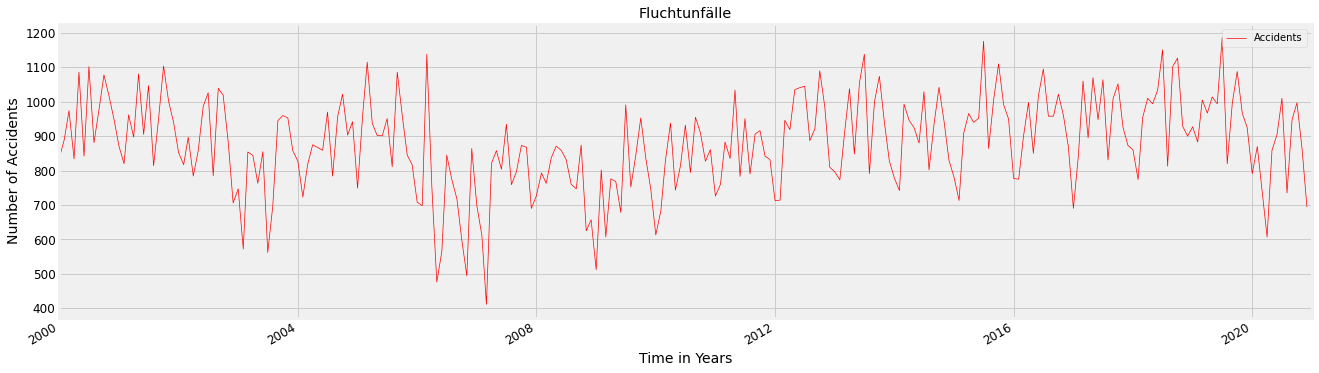

In [10]:
for i in range(len(categories)):
    
    ax=uni[i].plot(figsize=(20, 6),color='red',linewidth=0.7)

    ax.set_xlabel('Time in Years')

    ax.set_ylabel('Number of Accidents')

    ax.set_title(categories[i])

    ax.grid(True)

    ax.set_xlim(pd.Timestamp('2000'), pd.Timestamp('2021'))

    ax.legend(labels=['Accidents'],loc='upper right');

    plt.show()
    
    print('\n\n')

# Initial observations

* The time series for all three categories does not exhibit any clear trend. Furthermore, a slight decrease in alcohol accidents can be seen from 2008 onwards which might suggest better law enforcement and rules during this period.

* An unexpected drop in Traffic accidents (Verkehrdunfalle) can be seen around Mar'20 - Arp'20 perhaps due to Covid restrictions in Munich.

# Individual Plots for last 5 years (for better analysis)

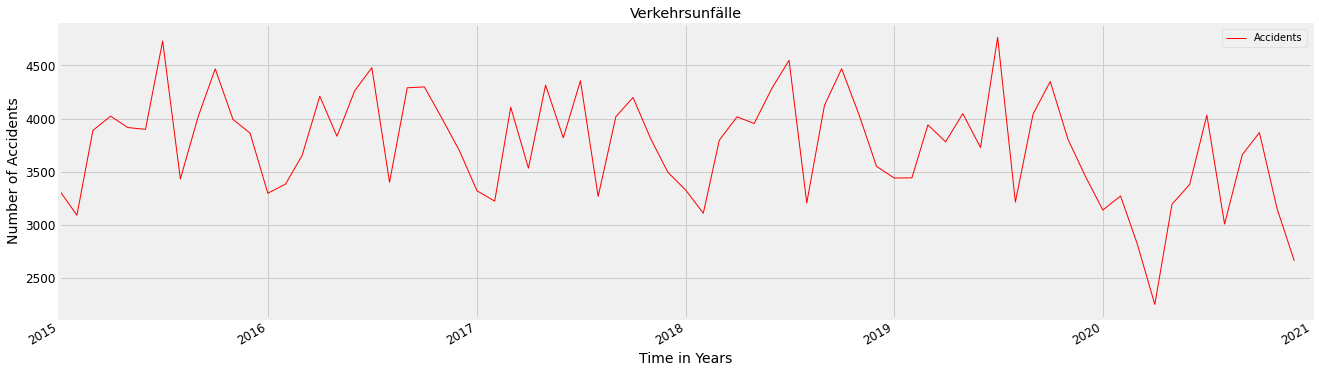

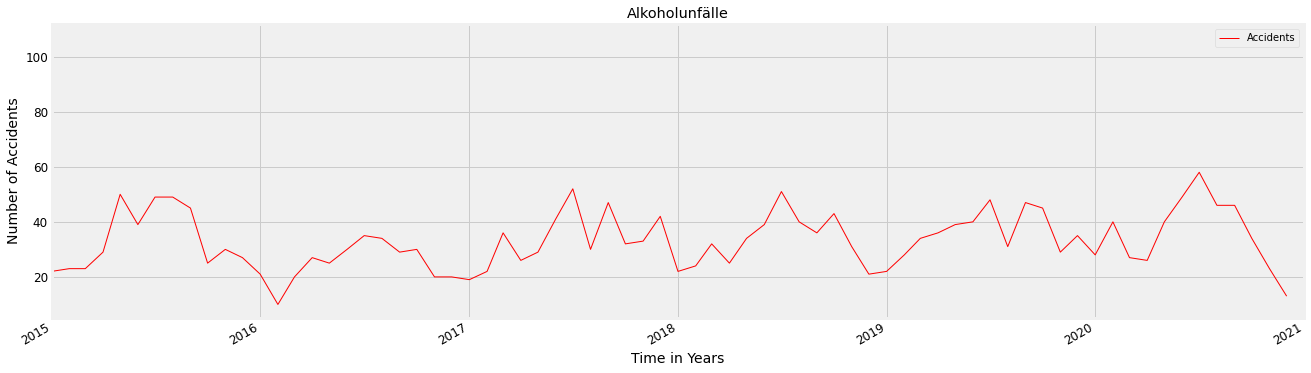

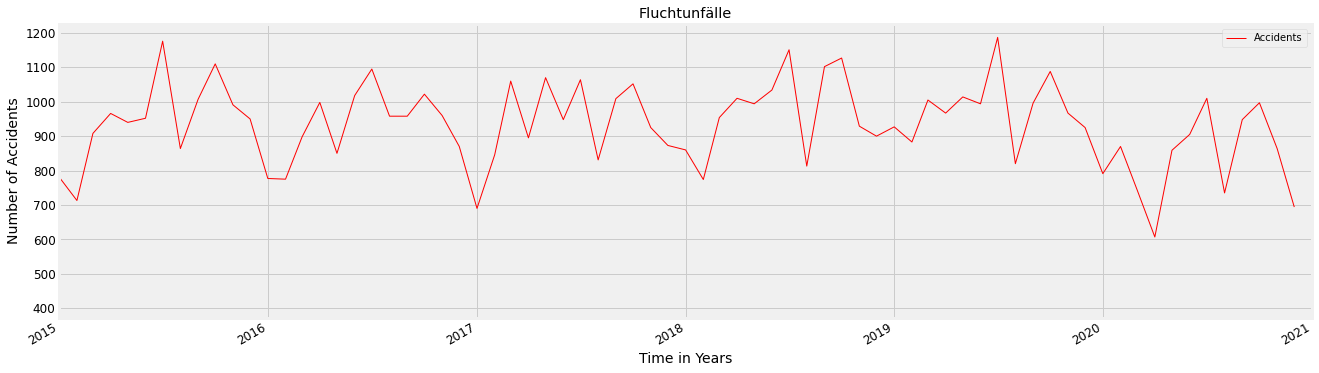

In [11]:
for i in range(len(categories)):
    
    ax=uni[i].plot(figsize=(20, 6),color='red',linewidth=1)

    ax.set_xlabel('Time in Years')

    ax.set_ylabel('Number of Accidents')

    ax.set_title(categories[i])

    ax.grid(True)

    ax.set_xlim(pd.Timestamp('2015-01-01'), pd.Timestamp('2021-01-01'))

    ax.legend(labels=['Accidents'],loc='upper right');

    plt.show()
    
    print('\n\n')

# Initial observations

* Clear seasonality can be seen in all three categories wherein the accidents increase particularly in summers i.e. May-July and are often followed by a sudden decrease in accidents in Aug-Sept.

* As mentioned earlier, a clear decrease in accidents can be seen around Mar'20 - Apr'20 probably due to Covid restrictions and lack of Traffic and other public accidents.

* An increase in alcohol accidents can be seen just after the Covid restrictions period. An hypothesis stating the increase of alcohol consumption after ease in restrictions can be seen thus hinting at psychological discomfort during restrictions amongst people.

# Overlapping graphs (Not Normalized)

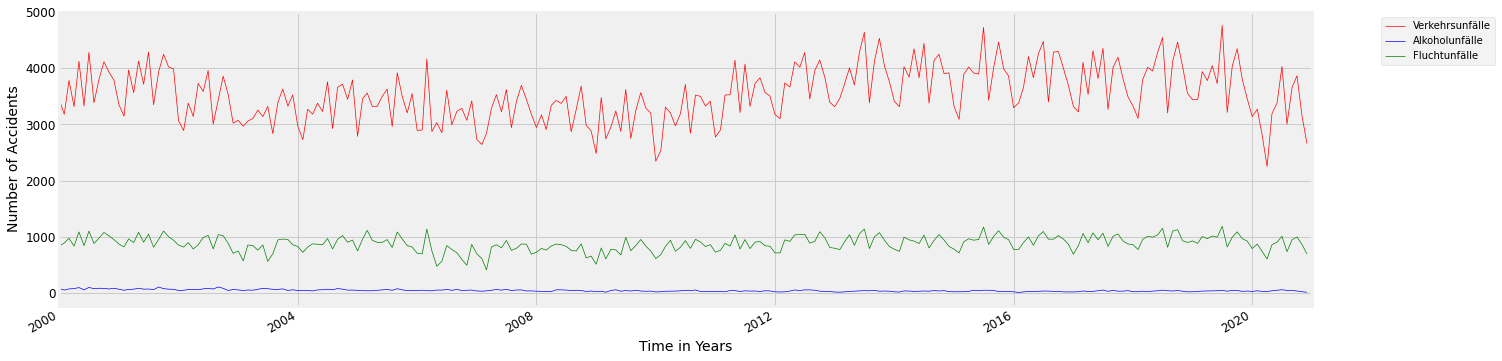

In [12]:
colours=['red','blue','green']

for i in range(len(categories)):
    
    ax=uni[i].plot(figsize=(20, 6),color=colours[i],linewidth=0.7)

    ax.set_xlabel('Time in Years')

    ax.set_ylabel('Number of Accidents')

    ax.grid(True)

    ax.set_xlim(pd.Timestamp('2000-01-01'), pd.Timestamp('2021-01-01'))

    ax.legend(labels=[categories[0],categories[1],categories[2]],loc='upper right',bbox_to_anchor=(1.15, 1));

plt.show()

# Normalization

In [13]:
nmz=[]
for i in uni:
    values = np.array(i)
    values = values.reshape((len(values), 1))
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(values)
    normalized = scaler.transform(values)
    nmz.append(normalized)

In [14]:
normalize_plot=[]
for i in nmz:
    tmp=pd.DataFrame()
    cur=[]
    for j in i:
        cur.append(j.tolist()[0])
    tmp['value']=cur
    tmp = tmp.set_index(uni[0].index)
    normalize_plot.append(tmp['value'])   

# Normalized graphs

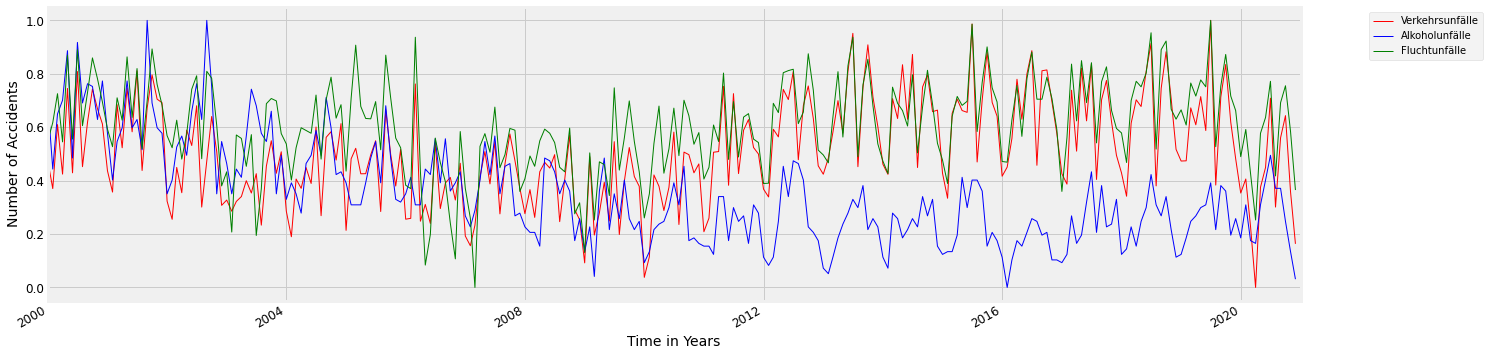

In [15]:
colours=['red','blue','green']

for i in range(len(categories)):
    
    ax=normalize_plot[i].plot(figsize=(20, 6),color=colours[i],linewidth=1)

    ax.set_xlabel('Time in Years')

    ax.set_ylabel('Number of Accidents')

    ax.grid(True)

    ax.set_xlim(pd.Timestamp('2000-01-01'), pd.Timestamp('2021-01-01'))

    ax.legend(labels=[categories[0],categories[1],categories[2]],loc='upper right',bbox_to_anchor=(1.15, 1));

plt.show()

# Selected category for prediction : 

In [40]:
for i in uni:
    i.sort_index(inplace= True)
data=uni[1]

In [41]:
data

Month
2000-01-01    78.0
2000-02-01    53.0
2000-03-01    73.0
2000-04-01    78.0
2000-05-01    96.0
              ... 
2020-08-01    46.0
2020-09-01    46.0
2020-10-01    34.0
2020-11-01    23.0
2020-12-01    13.0
Name: Value, Length: 252, dtype: float64

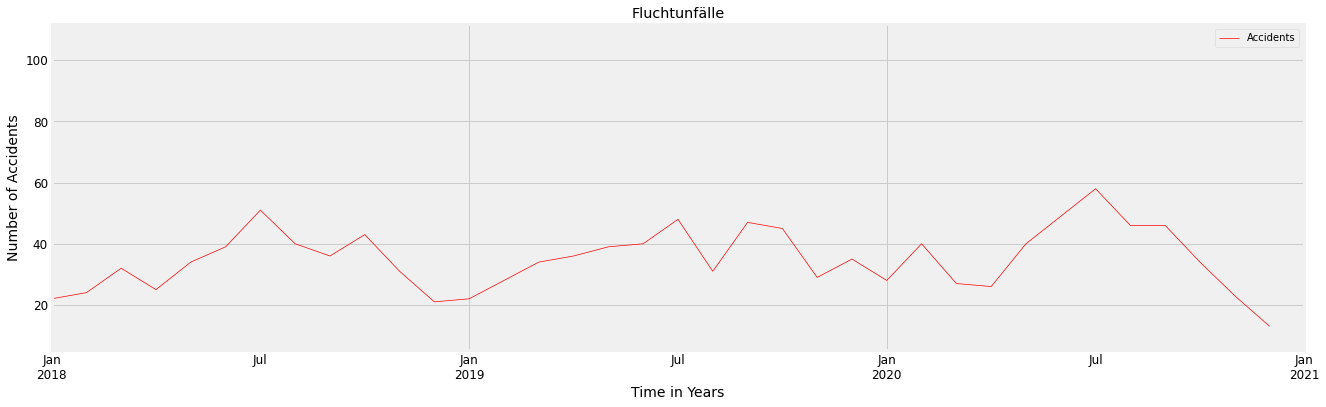

In [42]:
ax=data.plot(figsize=(20, 6),color='red',linewidth=0.7)

ax.set_xlabel('Time in Years')

ax.set_ylabel('Number of Accidents')

ax.set_title(categories[2])

ax.grid(True)

ax.set_xlim(pd.Timestamp('2018'), pd.Timestamp('2021'))

ax.legend(labels=['Accidents'],loc='upper right');

plt.show()

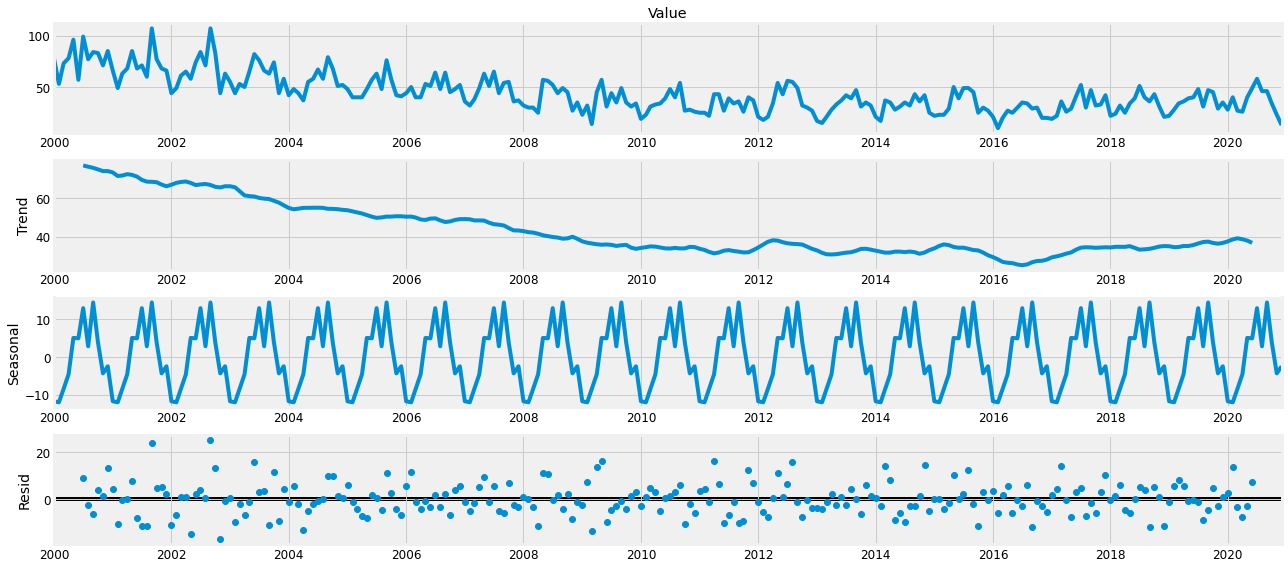

In [43]:
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(data, model='additive')

fig = decomposition.plot()

plt.show()

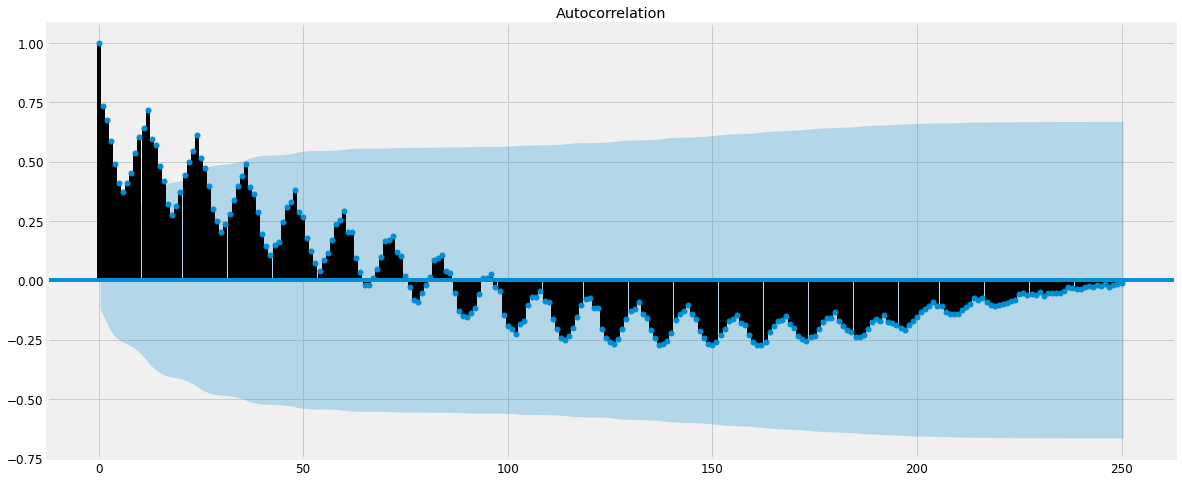

In [44]:
acf=plot_acf(data,lags=250)

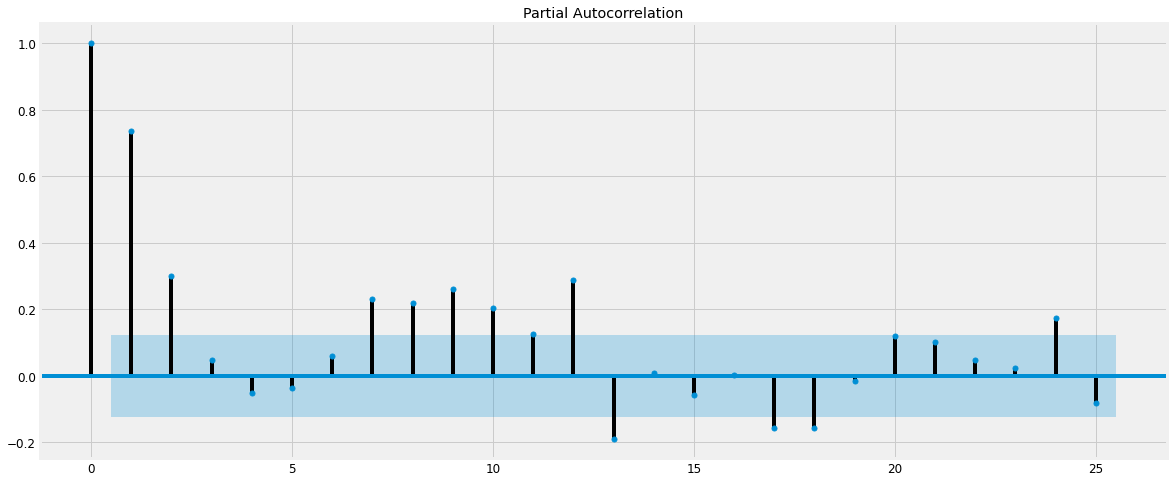

In [45]:
acf=plot_pacf(data)

In [46]:
data

Month
2000-01-01    78.0
2000-02-01    53.0
2000-03-01    73.0
2000-04-01    78.0
2000-05-01    96.0
              ... 
2020-08-01    46.0
2020-09-01    46.0
2020-10-01    34.0
2020-11-01    23.0
2020-12-01    13.0
Name: Value, Length: 252, dtype: float64

In [47]:
data.index = pd.DatetimeIndex(data.index.values,freq=y.index.inferred_freq)

In [48]:
def test_stationarity(timeseries,maxlag):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries,maxlag=maxlag,
                      autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (round(dfoutput,3))
test_stationarity(data,maxlag=4)

Results of Dickey-Fuller Test:
Test Statistic                  -4.025
p-value                          0.001
#Lags Used                       1.000
Number of Observations Used    250.000
Critical Value (1%)             -3.457
Critical Value (5%)             -2.873
Critical Value (10%)            -2.573
dtype: float64


# SARIMAX Parameter Calculation via Grid Search

In [50]:
def sarimax(ts,all_param):
    results = []
    cons=[]
    best=float('inf')
    for param in all_param:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts,order=param[0],seasonal_order=param[1],enforce_stationarity=False,enforce_invertibility=False)
            res = mod.fit()
            results.append((res,res.aic,param))
            print('Tried out SARIMAX{}x{} - AIC:{}'.format(param[0], param[1], round(res.aic,2)))
            if res.aic<best:
                best=res.aic
                cons=[param]
        except Exception as e:
            print(e)
            continue
            
    return results,cons,best

# set parameter range
p,d,q = range(0,3),[1],range(0,3)
P,D,Q,s = range(0,3),[1],range(0,3),[12]

# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))
all_param = list(itertools.product(pdq,seasonal_pdq))
all_res,cons,best = sarimax(data,all_param)

Tried out SARIMAX(0, 1, 0)x(0, 1, 0, 12) - AIC:1906.9
Tried out SARIMAX(0, 1, 0)x(0, 1, 1, 12) - AIC:1703.18
Tried out SARIMAX(0, 1, 0)x(0, 1, 2, 12) - AIC:1595.47
Tried out SARIMAX(0, 1, 0)x(1, 1, 0, 12) - AIC:1748.58
Tried out SARIMAX(0, 1, 0)x(1, 1, 1, 12) - AIC:1698.68
Tried out SARIMAX(0, 1, 0)x(1, 1, 2, 12) - AIC:1596.52
Tried out SARIMAX(0, 1, 0)x(2, 1, 0, 12) - AIC:1609.53
Tried out SARIMAX(0, 1, 0)x(2, 1, 1, 12) - AIC:1596.86
Tried out SARIMAX(0, 1, 0)x(2, 1, 2, 12) - AIC:1583.84
Tried out SARIMAX(0, 1, 1)x(0, 1, 0, 12) - AIC:1795.23
Tried out SARIMAX(0, 1, 1)x(0, 1, 1, 12) - AIC:1598.87
Tried out SARIMAX(0, 1, 1)x(0, 1, 2, 12) - AIC:1501.61
Tried out SARIMAX(0, 1, 1)x(1, 1, 0, 12) - AIC:1650.85
Tried out SARIMAX(0, 1, 1)x(1, 1, 1, 12) - AIC:1596.58
Tried out SARIMAX(0, 1, 1)x(1, 1, 2, 12) - AIC:1502.01
Tried out SARIMAX(0, 1, 1)x(2, 1, 0, 12) - AIC:1519.28
Tried out SARIMAX(0, 1, 1)x(2, 1, 1, 12) - AIC:1513.81
Tried out SARIMAX(0, 1, 1)x(2, 1, 2, 12) - AIC:1497.06
Tried out S

In [51]:
best

1484.9715523763407

In [65]:
cons[0]

((0, 1, 2), (2, 1, 2, 12))

# Best parameters

In [67]:
mod = sm.tsa.statespace.SARIMAX(data,
                                order=cons[0][0],
                                seasonal_order=cons[0][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print('ARIMA{}x{}12 - AIC:{}'.format(cons[0][0], cons[0][1], results.aic))

ARIMA(0, 1, 2)x(2, 1, 2, 12)12 - AIC:1484.9715523763407


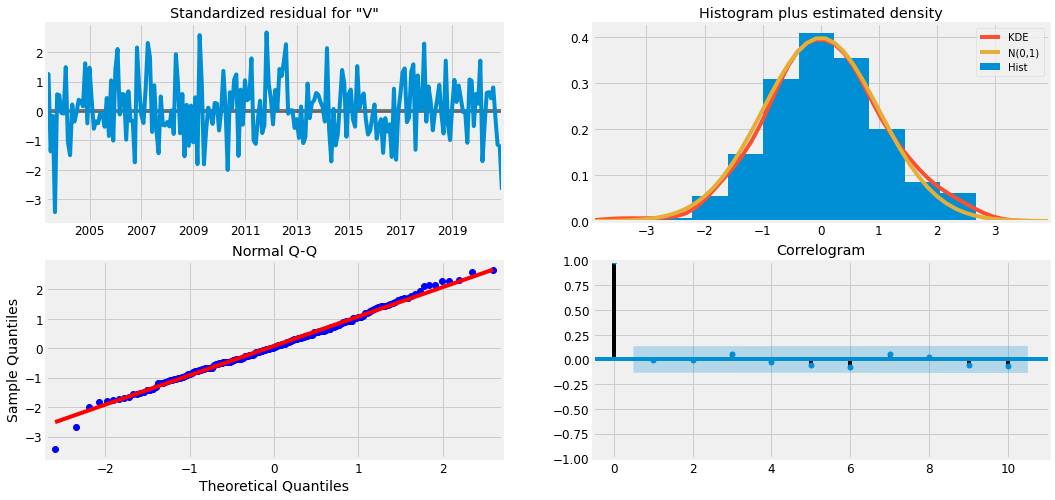

In [68]:
results.plot_diagnostics(figsize=(16, 8))

plt.show()

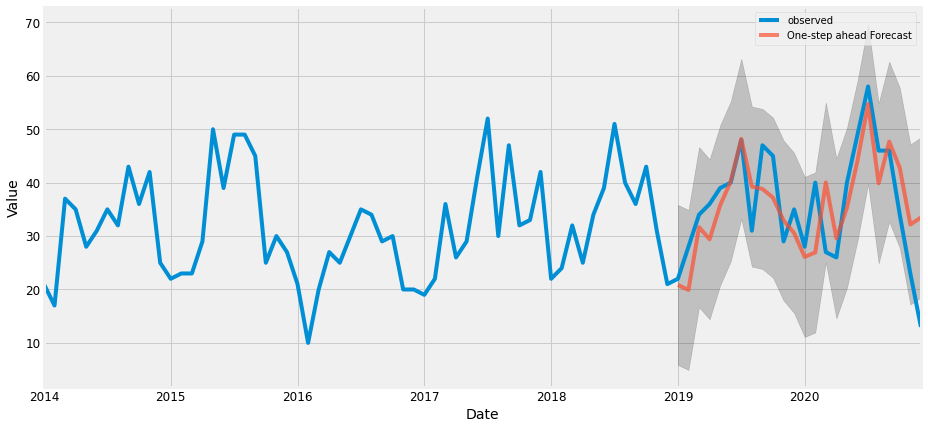

In [69]:
pred = results.get_prediction(start=pd.to_datetime('2019-01-01'), dynamic=False)

pred_ci = pred.conf_int()

ax = data['2014':].plot(label='observed')

pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,pred_ci.iloc[:, 0],pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')

ax.set_ylabel('Value')

plt.legend()

plt.show()

In [70]:
data_forecasted = pred.predicted_mean
data_truth = data['2019-01-01':]
mse = ((data_forecasted - data_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 57.99
The Root Mean Squared Error of our forecasts is 7.62


# Saving the model

In [168]:
outfile=open("ARIMA_Alkoholunfälle_Verletzte.sav","wb")
pickle.dump(results,outfile)
outfile.close()

# Trying out HWES model

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Value   No. Observations:                  228
Model:             ExponentialSmoothing   SSE                          14382.213
Optimized:                         True   AIC                            976.924
Trend:                         Additive   BIC                           1031.793
Seasonal:                Multiplicative   AICC                           980.196
Seasonal Periods:                    12   Date:                 Fri, 16 Jul 2021
Box-Cox:                          False   Time:                         23:54:42
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0818669                alpha                 True
smoothing_trend          

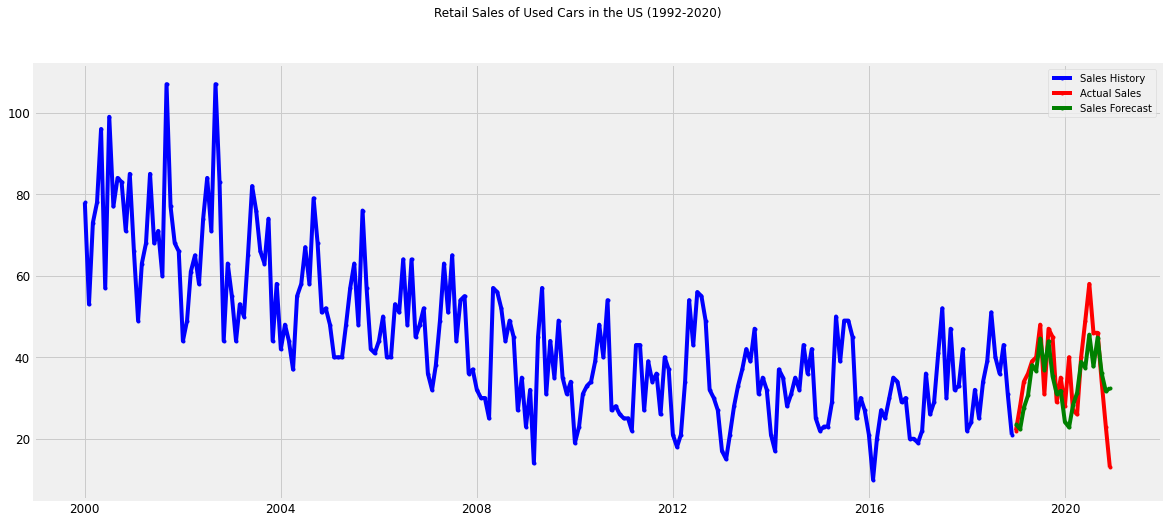

In [81]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES

df_train = data.iloc[:-24]
df_test = data.iloc[-24:]

model = HWES(df_train, seasonal_periods=12,trend='add',seasonal='multiplicative')
fitted = model.fit(optimized=True, use_brute=True)

#print out the training summary
print(fitted.summary())

#create an out of sample forcast for the next 12 steps beyond the final data point in the training data set
forecast = fitted.forecast(steps=24)

#plot the training data, the test data and the forecast on the same plot
fig = plt.figure()
fig.suptitle('Retail Sales of Used Cars in the US (1992-2020)')
past, = plt.plot(df_train.index, df_train, 'b.-', label='Sales History')
future, = plt.plot(df_test.index, df_test, 'r.-', label='Actual Sales')
predicted_future, = plt.plot(df_test.index, forecast, 'g.-', label='Sales Forecast')
plt.legend(handles=[past, future, predicted_future])
plt.show()

In [83]:
data_forecasted = forecast
data_truth = data['2019-01-01':]
mse = ((data_forecasted - data_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 59.9
The Root Mean Squared Error of our forecasts is 7.74


# DL

In [84]:
# plot utils.
def plot_scatter(*args, **kwargs):
    plt.plot(*args, **kwargs)
    plt.scatter(*args, **kwargs)


# simple batcher.
def data_generator(x, y, size):
    assert len(x) == len(y)
    batches = []
    for ii in range(0, len(x), size):
        batches.append((x[ii:ii + size], y[ii:ii + size]))
    for batch in batches:
        yield batch

| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=256, thetas_dim=4, backcast_length=12, forecast_length=6, share_thetas=False) at @2007678369504
     | -- GenericBlock(units=256, thetas_dim=4, backcast_length=12, forecast_length=6, share_thetas=False) at @2007678367584
     | -- GenericBlock(units=256, thetas_dim=4, backcast_length=12, forecast_length=6, share_thetas=False) at @2007678367680
| --  Stack Generic (#1) (share_weights_in_stack=False)
     | -- GenericBlock(units=256, thetas_dim=8, backcast_length=12, forecast_length=6, share_thetas=False) at @2007678366528
     | -- GenericBlock(units=256, thetas_dim=8, backcast_length=12, forecast_length=6, share_thetas=False) at @2007678366384
     | -- GenericBlock(units=256, thetas_dim=8, backcast_length=12, forecast_length=6, share_thetas=False) at @2007678366864


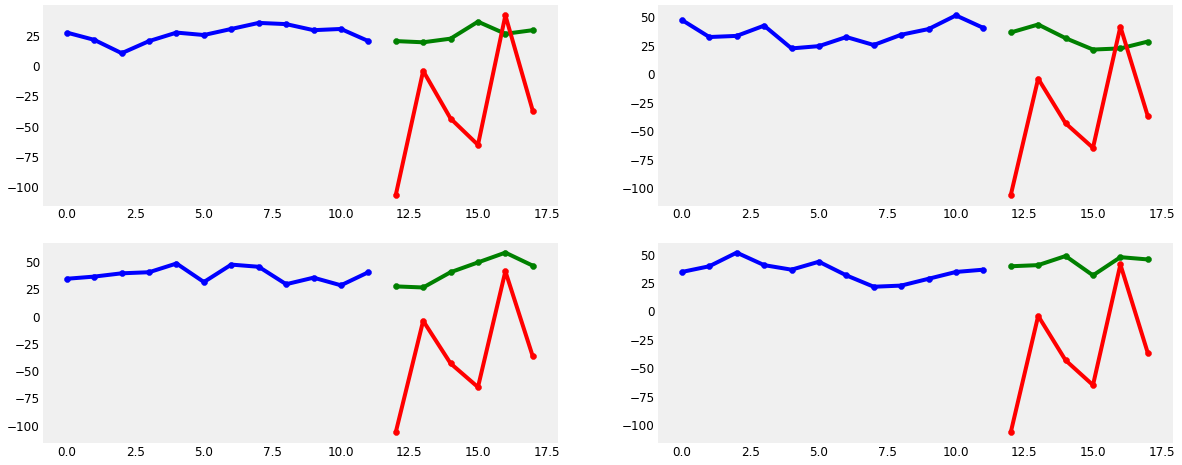

epoch = 0000, grad_step = 000019, tr_loss (epoch) = 546.713, te_loss (epoch) = 441.888


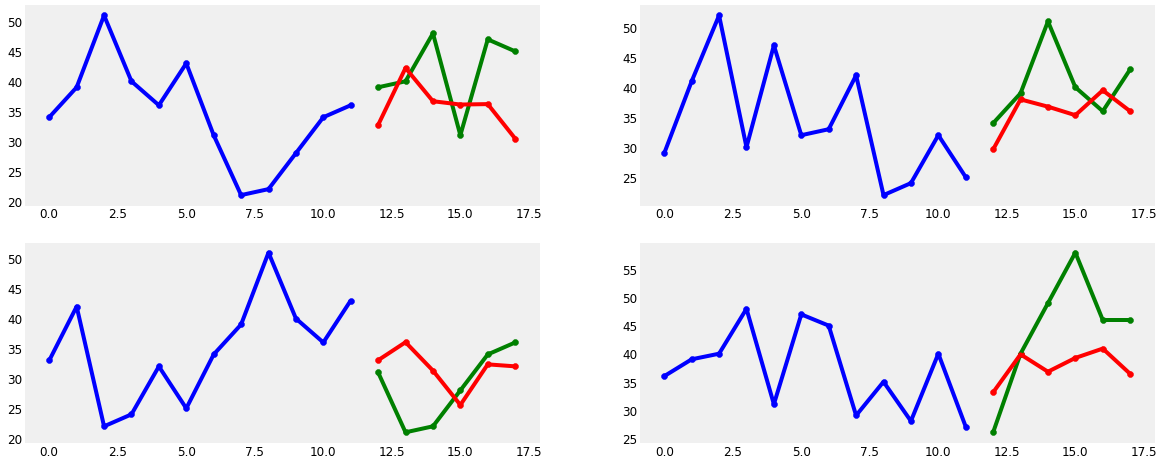

epoch = 0100, grad_step = 001919, tr_loss (epoch) = 6.222, te_loss (epoch) = 4.448


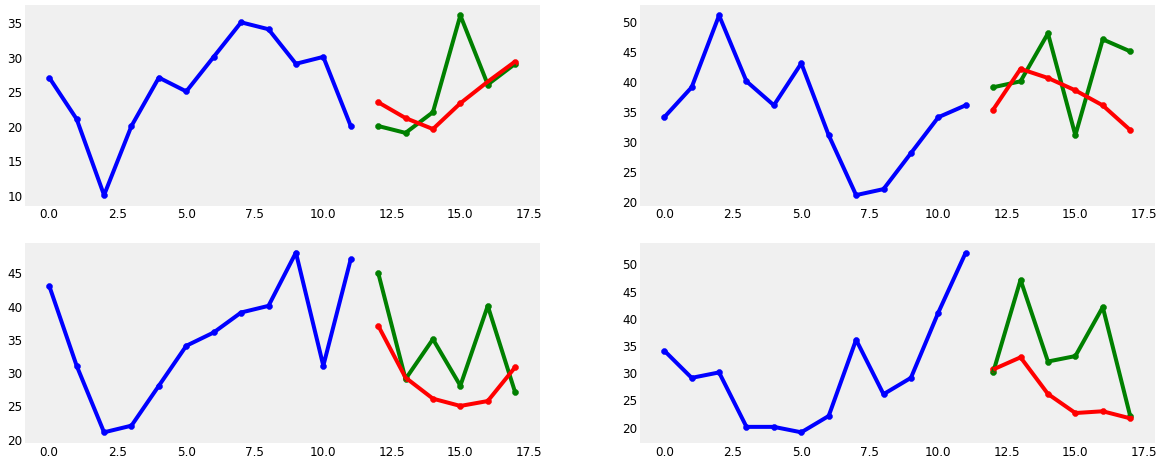

epoch = 0200, grad_step = 003819, tr_loss (epoch) = 4.633, te_loss (epoch) = 4.437


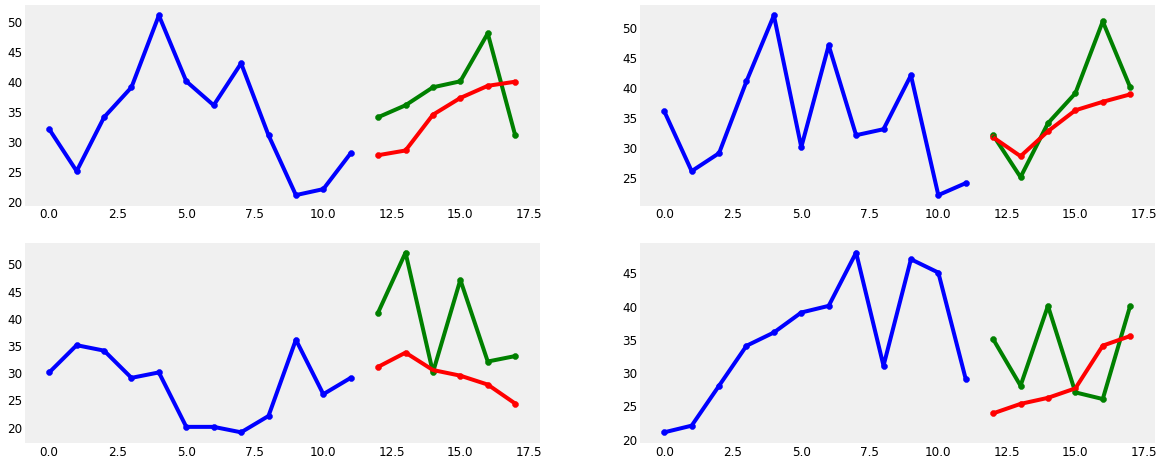

epoch = 0300, grad_step = 005719, tr_loss (epoch) = 4.205, te_loss (epoch) = 4.354


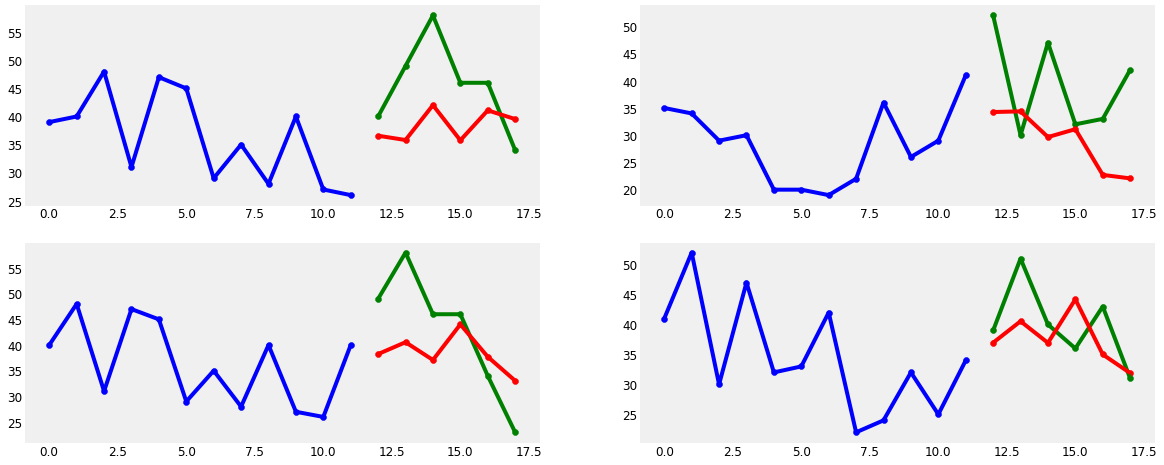

epoch = 0400, grad_step = 007619, tr_loss (epoch) = 3.841, te_loss (epoch) = 4.313


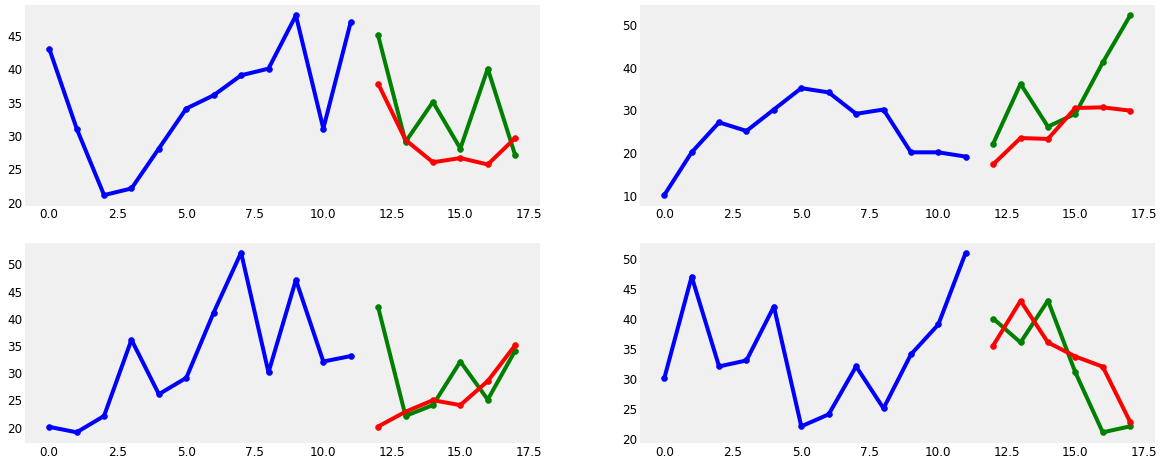

epoch = 0500, grad_step = 009519, tr_loss (epoch) = 3.510, te_loss (epoch) = 4.293


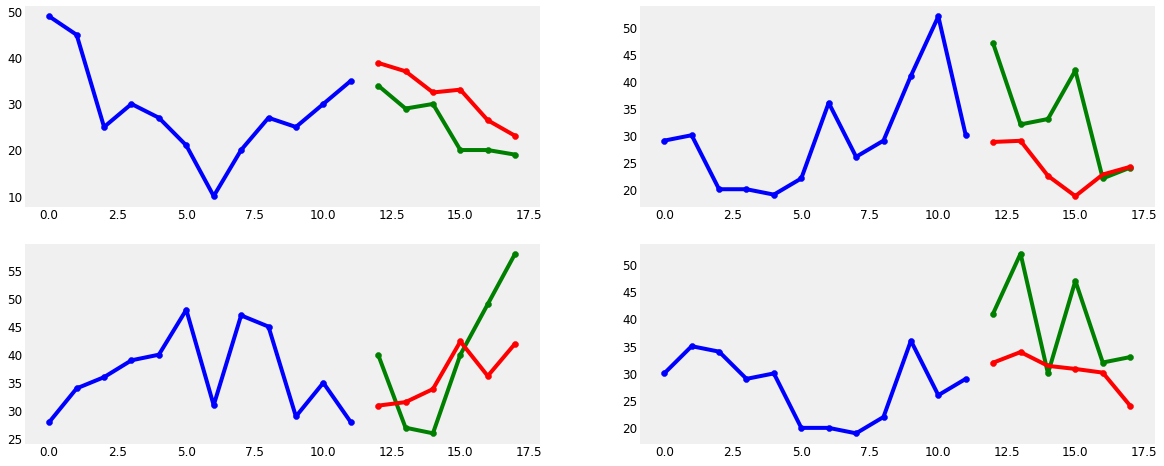

epoch = 0600, grad_step = 011419, tr_loss (epoch) = 3.207, te_loss (epoch) = 4.295


In [103]:
 # just keep np array here for simplicity.
forecast_length = 6
backcast_length = 12
batch_size = 10  # greater than 4 for viz
# data backcast/forecast generation.
milk = data
milk = milk.values.flatten()
x, y = [], []
for epoch in range(backcast_length, len(milk) - forecast_length):
    x.append(milk[epoch - backcast_length:epoch])
    y.append(milk[epoch:epoch + forecast_length])
x = np.array(x)
y = np.array(y)

# split train/test.
c = int(len(x) * 0.8)
x_train, y_train = x[:c], y[:c]
x_test, y_test = x[c:], y[c:]

# normalization.
norm_constant = np.max(x_train)
x_train, y_train = x_train / norm_constant, y_train / norm_constant
x_test, y_test = x_test / norm_constant, y_test / norm_constant

# model
net = NBeatsNet(
    stack_types=(NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK),
    forecast_length=forecast_length,
    backcast_length=backcast_length,
    hidden_layer_units=256,
)
optimiser = optim.Adam(lr=1e-5, params=net.parameters())

grad_step = 0
for epoch in range(700):
    # train.
    net.train()
    train_loss = []
    for x_train_batch, y_train_batch in data_generator(x_train, y_train, batch_size):
        grad_step += 1
        optimiser.zero_grad()
        _, forecast = net(torch.tensor(x_train_batch, dtype=torch.float).to(net.device))
        loss = F.mse_loss(forecast, torch.tensor(y_train_batch, dtype=torch.float).to(net.device))
        train_loss.append(loss.item())
        loss.backward()
        optimiser.step()
    train_loss = np.mean(train_loss)

    # test.
    net.eval()
    _, forecast = net(torch.tensor(x_test, dtype=torch.float))
    test_loss = F.mse_loss(forecast, torch.tensor(y_test, dtype=torch.float)).item()
    p = forecast.detach().numpy()
    if epoch % 100 == 0:
        subplots = [221, 222, 223, 224]
        plt.figure(1)
        for plot_id, i in enumerate(np.random.choice(range(len(x_test)), size=4, replace=False)):
            ff, xx, yy = p[i] * norm_constant, x_test[i] * norm_constant, y_test[i] * norm_constant
            plt.subplot(subplots[plot_id])
            plt.grid()
            plot_scatter(range(0, backcast_length), xx, color='b')
            plot_scatter(range(backcast_length, backcast_length + forecast_length), yy, color='g')
            plot_scatter(range(backcast_length, backcast_length + forecast_length), ff, color='r')
        plt.show()
        with torch.no_grad():
            save(net, optimiser, grad_step)
        print(f'epoch = {str(epoch).zfill(4)}, '
              f'grad_step = {str(grad_step).zfill(6)}, '
              f'tr_loss (epoch) = {700 * train_loss:.3f}, '
              f'te_loss (epoch) = {700 * test_loss:.3f}')

In [105]:
pickle.dump(net,open("Nbeats.sav","wb"))

In [106]:
inp=data[-24:-12].values.flatten()
_, forecast = net(torch.tensor(inp, dtype=torch.float))
p = forecast.detach().numpy()

In [113]:
p[0]

array([35.05195 , 18.498774, 31.423225, 35.91598 , 22.478176, 39.017056],
      dtype=float32)

In [111]:
pred.predicted_mean['2020'][:4]

2020-01-01    26.096005
2020-02-01    26.930264
2020-03-01    40.039851
2020-04-01    29.564366
Freq: MS, Name: predicted_mean, dtype: float64

In [108]:
data['2020':][:4]

2020-01-01    28.0
2020-02-01    40.0
2020-03-01    27.0
2020-04-01    26.0
Freq: MS, Name: Value, dtype: float64

In [110]:
data_forecasted[:4]

2019-01-01    23.631285
2019-02-01    22.328093
2019-03-01    27.579407
2019-04-01    30.637153
Freq: MS, dtype: float64

# Prophet